In [90]:
import random
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.utils import np_utils

In [91]:
# Base layer class to specify the Layer properites for Convolution, Maxpool, Activation, Dense Layers to inherit
class Layer:
    def __init__(self):
        self.input = None
        self.output = None
    def forward(self, input):
        pass

    def backward(self, output_gradient, learning_rate):
        pass

# Forward Propagation
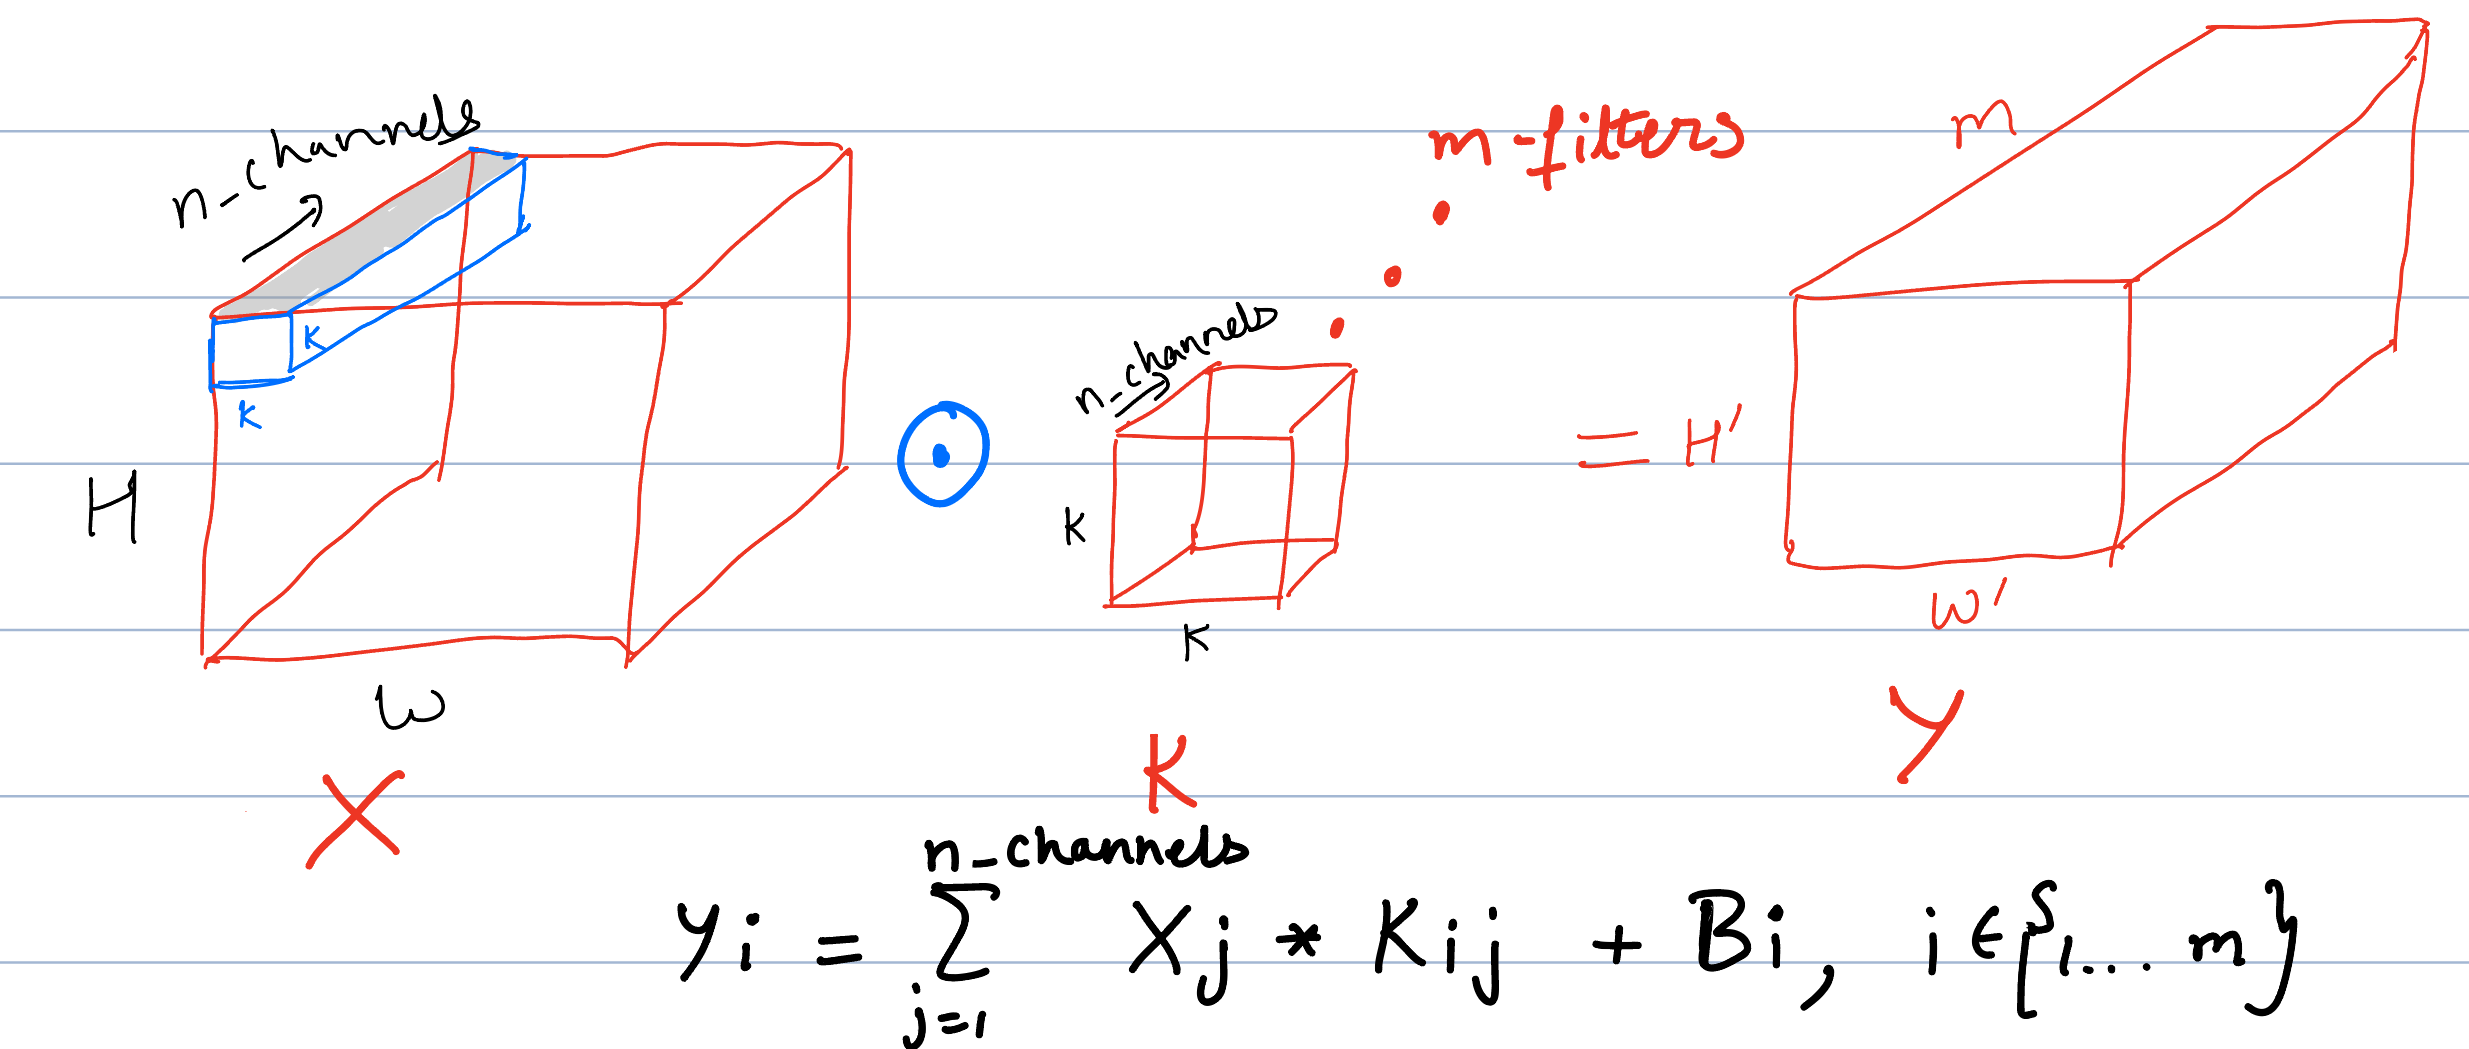

# Backward Propagation
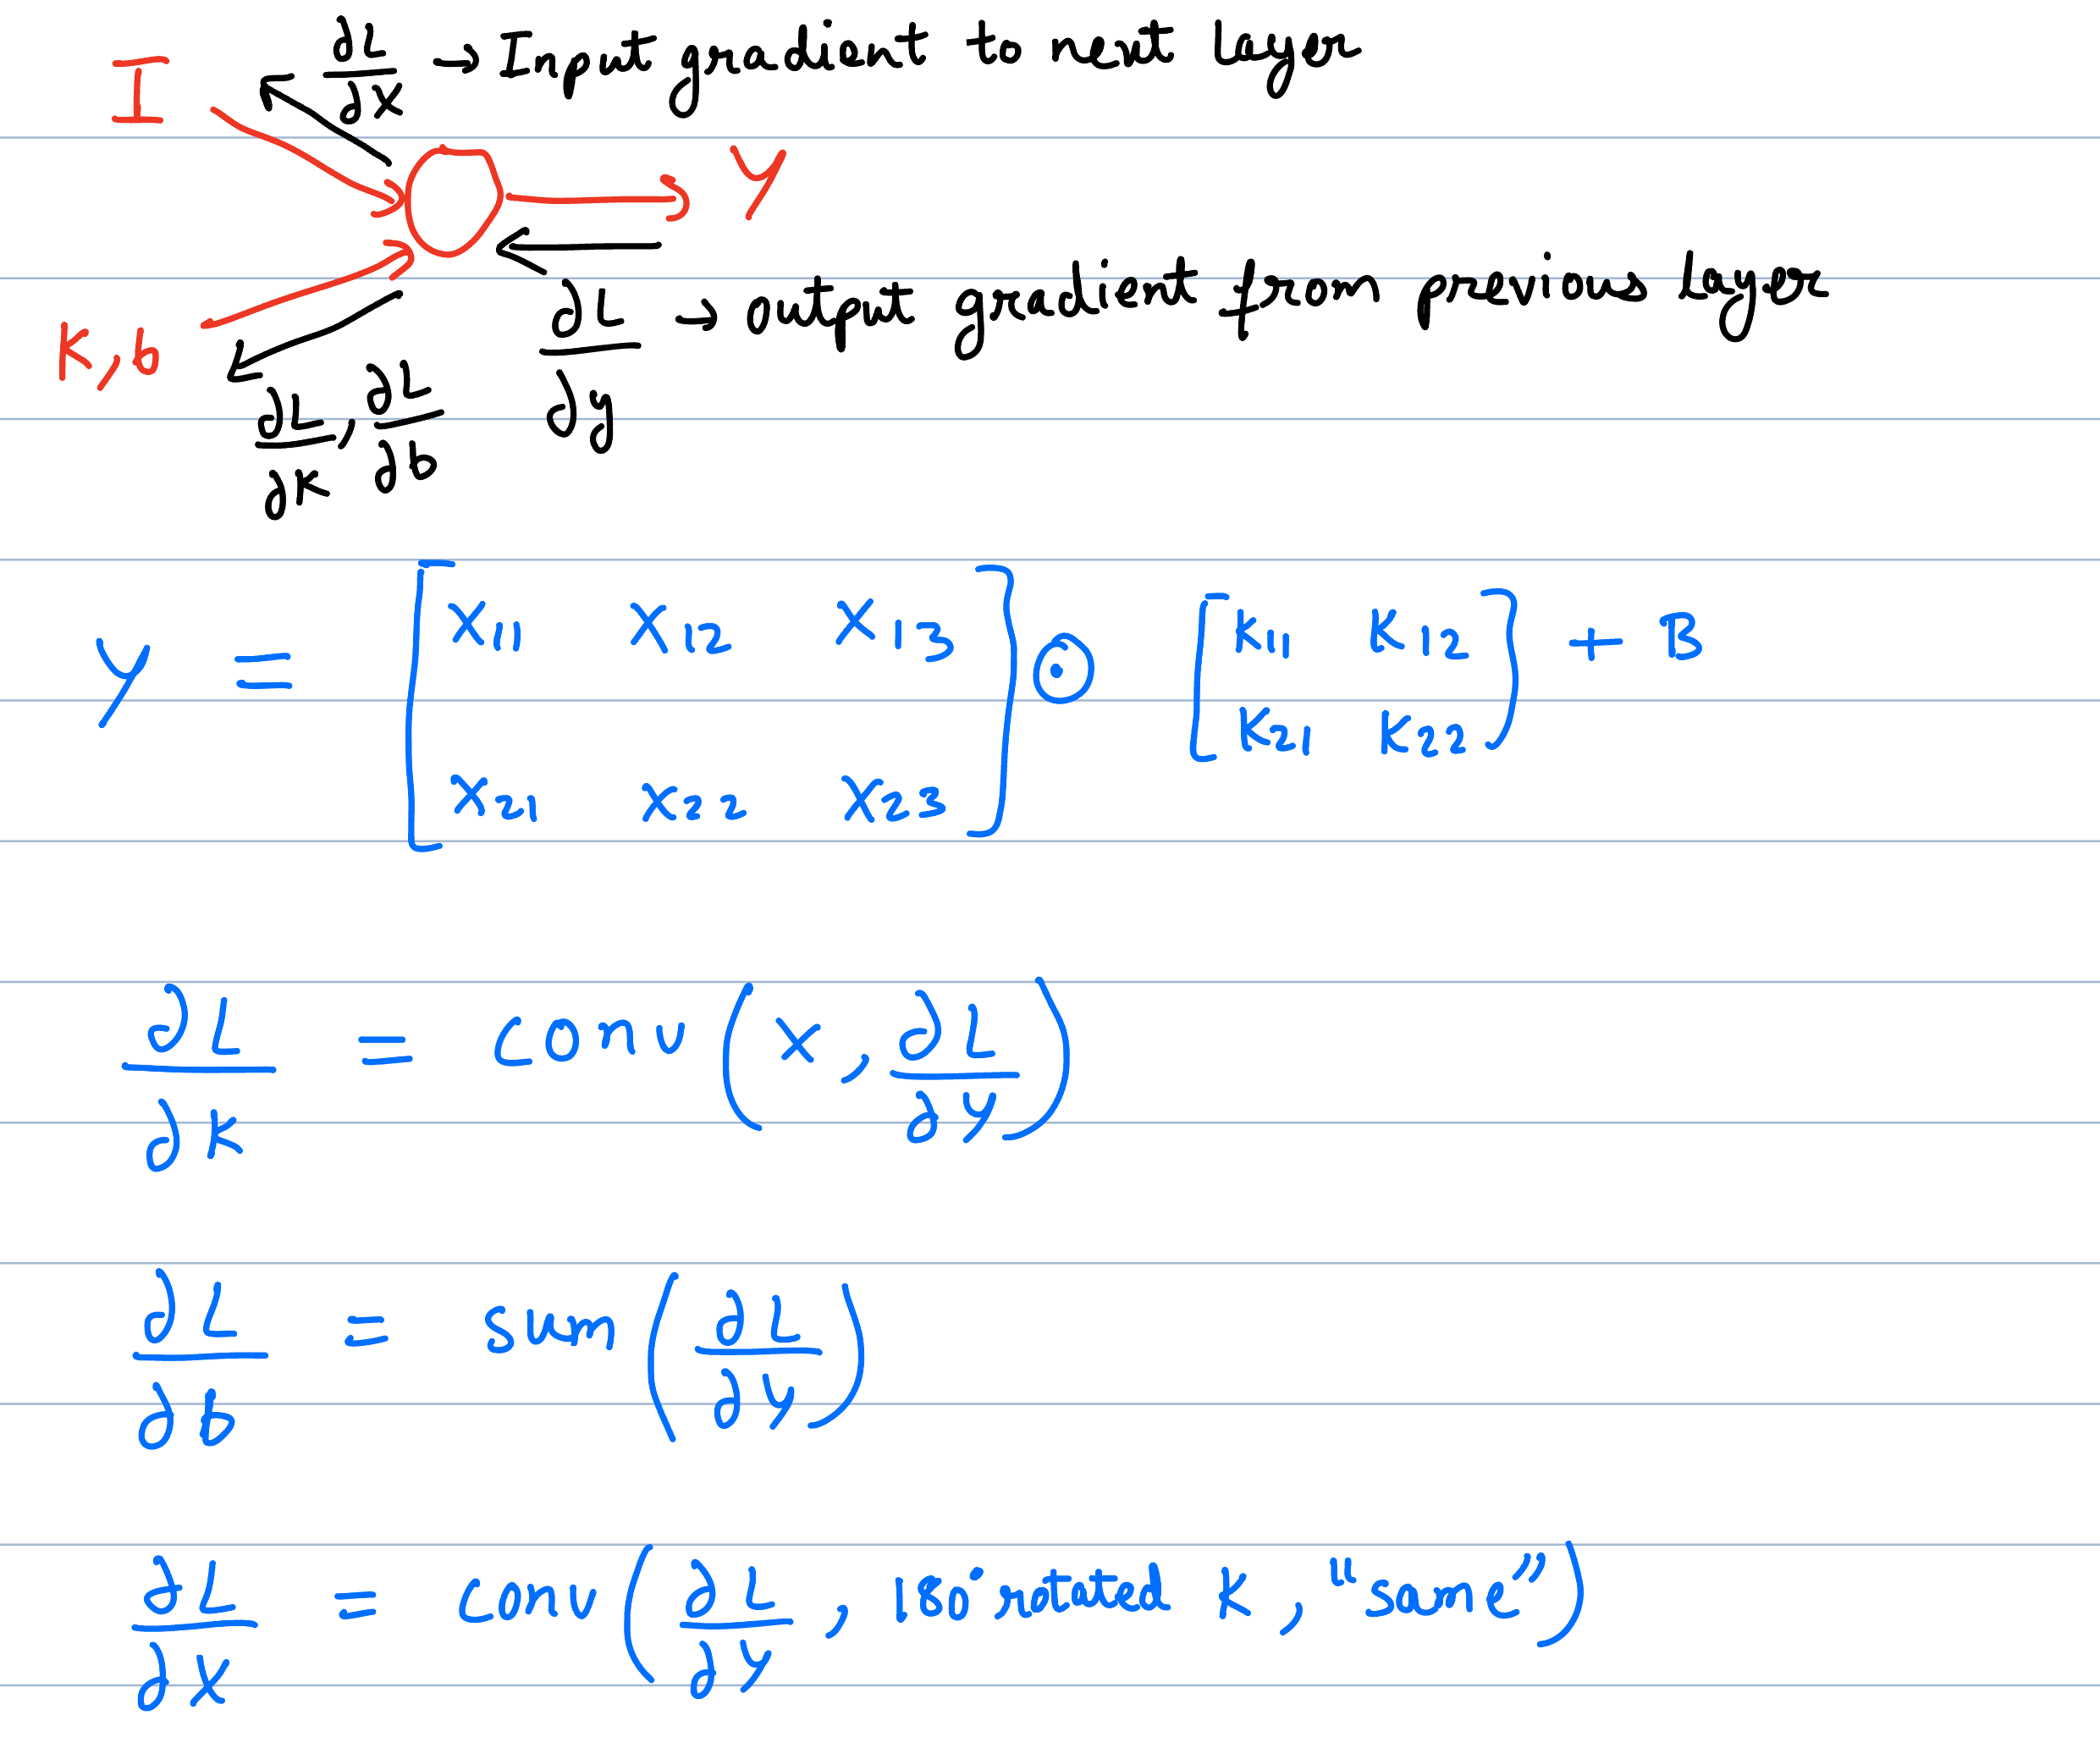

In [92]:
class Convolution(Layer):
    def __init__(self, input_shape, kernel_size, num_filters):
        # Input shape of an Image/Feature map
        n_channels, height, width = input_shape
        # Input depth of an Image/Feature map
        self.n_channels = n_channels
        # Depth or number of filters
        self.num_filters = num_filters
        self.input_shape = input_shape
        self.kernel_shape = (num_filters, n_channels, kernel_size, kernel_size)
        self.output_shape = (num_filters, height-kernel_size+1, width-kernel_size+1)
        # Randomly assign weights in filter and bias
        self.kernels = np.random.randn(*self.kernel_shape)
        self.biases = np.random.randn(*self.output_shape)      
    
    def forward(self, input):
        self.input = input
        self.output = np.zeros(self.output_shape)
        # Y = Conv(X, K)
        # signal.correlate2d performs convolution operation
        for i in range(self.num_filters):
            for j in range(self.n_channels):
                self.output[i] = self.biases[i] + signal.correlate2d(self.input[j], self.kernels[i,j], "valid")
        return self.output

    def backward(self, output_gradient, learning_rate):
        kernels_gradient = np.zeros(self.kernel_shape)
        input_gradient = np.zeros(self.input_shape)
        # dk = Conv(input, dy)
        # dI = Conv(dy, np.flip(K), "Same")
        for i in range(self.num_filters):
            for j in range(self.n_channels):
                kernels_gradient[i,j] = signal.correlate2d(self.input[j], output_gradient[i], "valid")
                input_gradient[j] += signal.correlate2d(output_gradient[i], np.flip(self.kernels[i,j]), "full")

        self.kernels -= learning_rate * kernels_gradient
        self.biases -= learning_rate * np.sum(output_gradient)
        return input_gradient

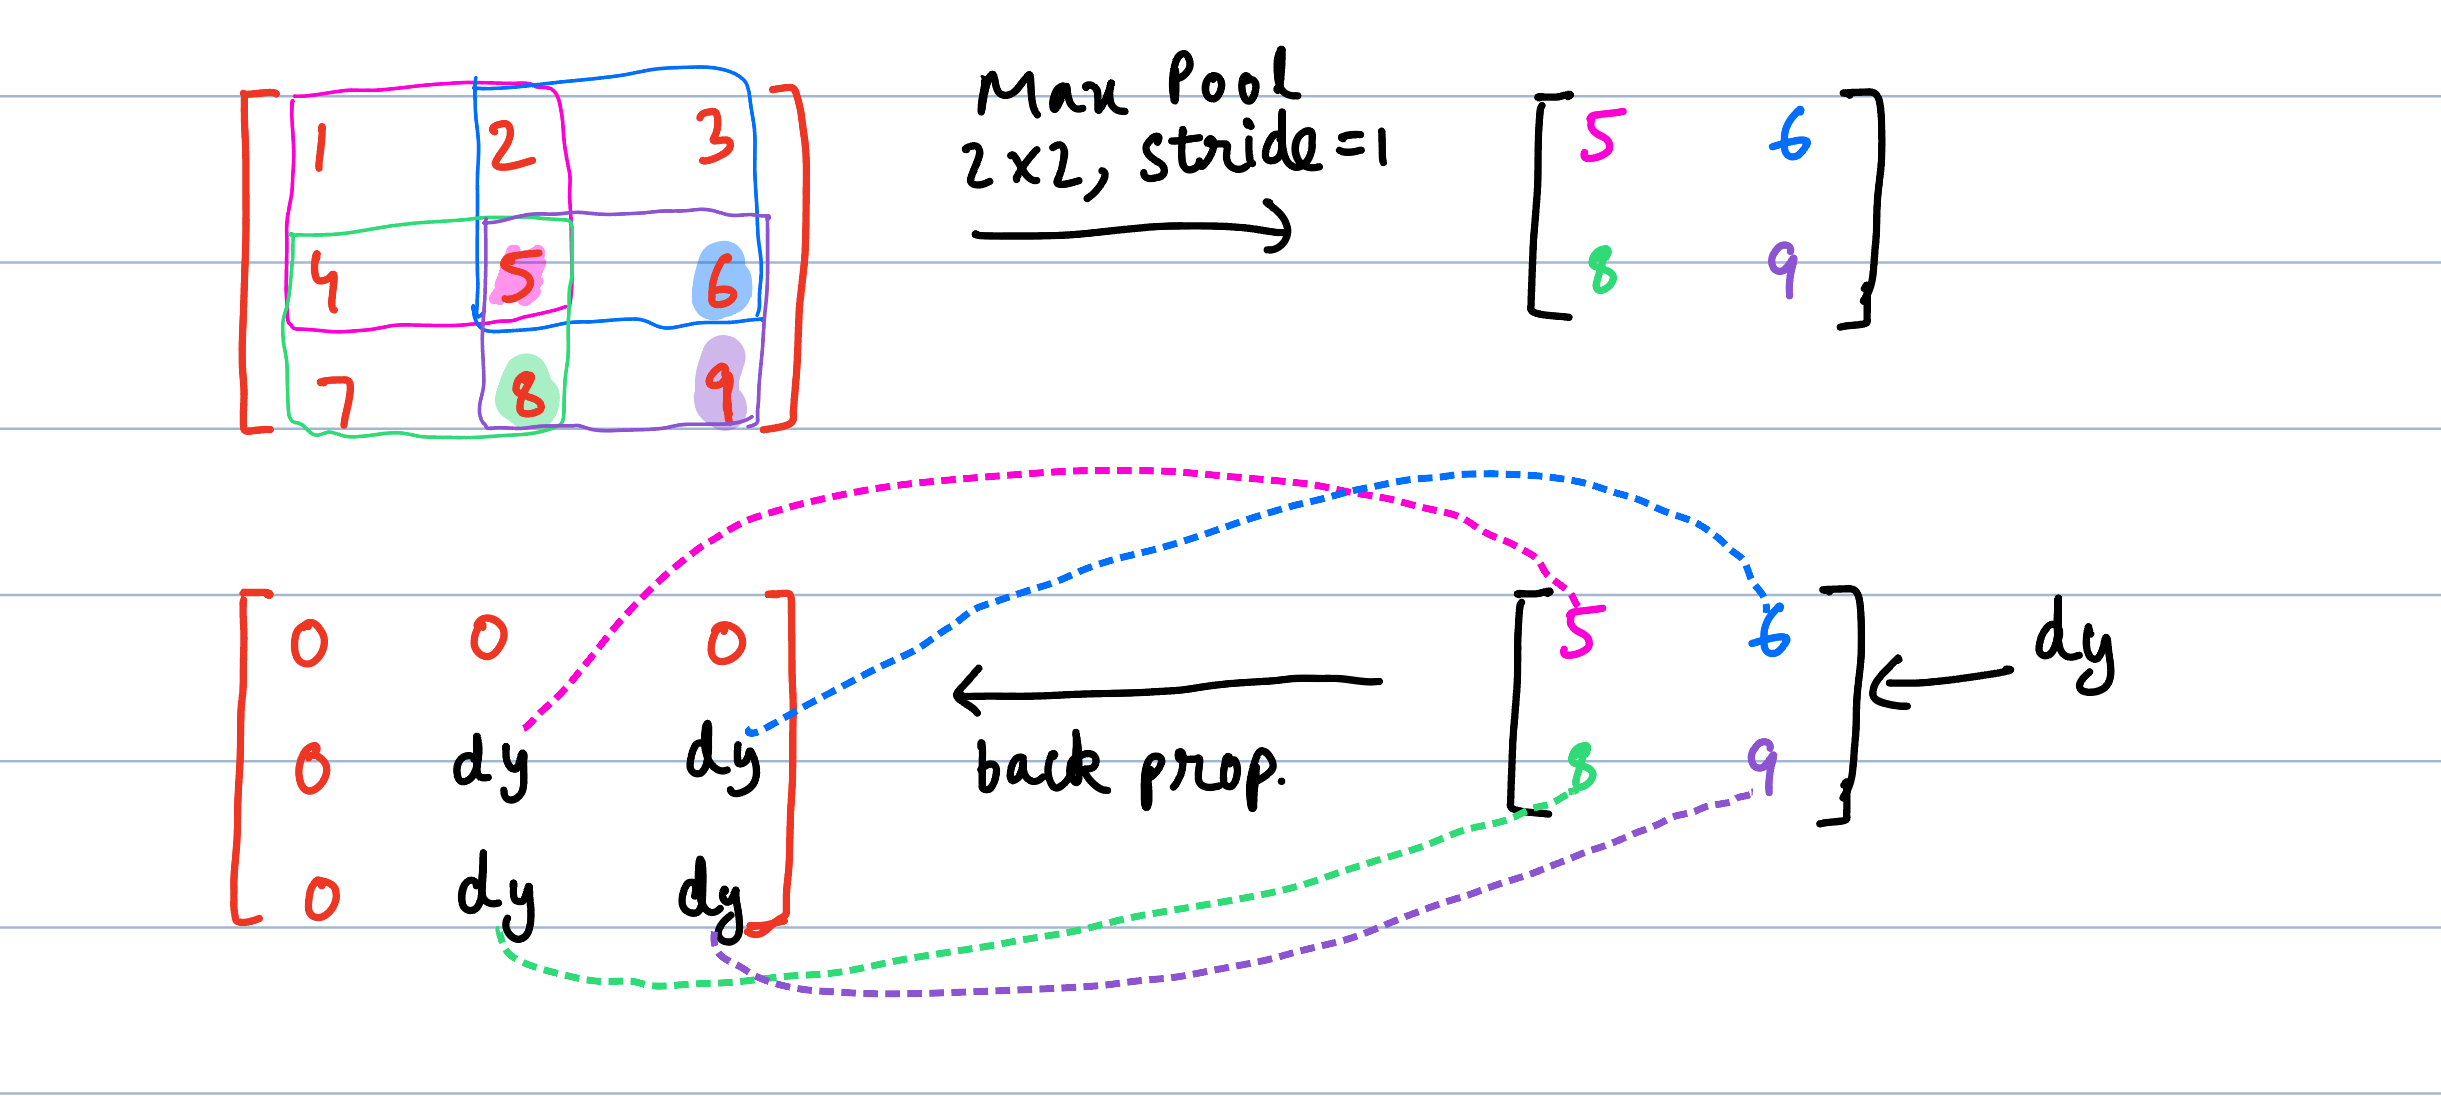

In [93]:
class Maxpool(Layer):
    def __init__(self, input_shape, kernel_size, num_filters):
        # Keeping stride = 1 for simplicity
        n_channels, height, width = input_shape
        self.n_channels = n_channels
        self.height = height
        self.width = width
        self.num_filters = num_filters
        self.input_shape = input_shape
        self.kernel_size = kernel_size
        self.kernel_shape = (num_filters, n_channels, kernel_size, kernel_size)
        self.kernels = np.random.randn(*self.kernel_shape)
        
    def forward(self, input):
        self.input = input
        new_height = self.height - self.kernel_size + 1
        new_width = self.width - self.kernel_size + 1
        self.output = np.zeros((self.n_channels, new_height, new_width))
        # Apply maxpool on each channel
        for k in range(self.n_channels):
            for h in range(0, self.height-1):
                for w in range(0, self.width-1):
                    self.output[k, h, w] = np.max(self.input[k, h:h+self.kernel_size, w:w+self.kernel_size])

        return self.output

    def backward(self, output_gradient, learning_rate):
        self.output_gradient = np.zeros(self.input_shape)
        dx = np.zeros(self.input_shape)
        
        for k in range(self.n_channels):
            for h in range(0, self.height-1):
                for w in range(0, self.width-1):
                    grad_pool = self.output[k, h:h+self.kernel_size, w:w+self.kernel_size]
                    mask = (grad_pool == np.max(grad_pool))
                    dx[k, h:h+self.kernel_size, w:w+self.kernel_size] = mask*self.output_gradient[k, h, w]

        return dx

In [94]:
#Base Activation class to specify the default properties of the Activation Layer from which we will derive our Activation functions ReLU, Softmax, TanH
class Activation(Layer):
    def __init__(self, activation, activation_prime):
        # Activation function
        self.activation = activation
        # Derivative of activation
        self.activation_prime = activation_prime

    def forward(self, input):
        self.input = input
        return self.activation(self.input)
    
    def backward(self, output_gradient, learning_rate):
        # Implement the backward function for the activation, by multiplying the output gradient and the derivative of the loss
        return np.multiply(output_gradient, self.activation_prime(self.input))

In [95]:
class ReLU(Activation):
    def __init__(self):
        def relu(x):
            return np.where(x>0, x, 0)
        
        def relu_prime(x):
            return np.where(x<=0, 0, 1)

        super().__init__(relu, relu_prime)

In [96]:
class TanH(Activation):
    def __init__(self):
        def tanh(x):
            return np.tanh(x)

        def tanh_prime(x):
            return 1 - np.tanh(x) ** 2

        super().__init__(tanh, tanh_prime)

In [97]:
class Softmax(Layer):
    def forward(self, input):
        e = np.exp(input)
        self.output = e/np.sum(e)
        return self.output
    
    def backward(self, output_gradient, learning_rate):
        n = np.size(self.output)
        return np.dot((np.identity(n) - self.output.T) * self.output, output_gradient)

In [98]:
class Reshape(Layer):
    def __init__(self, input_shape, output_shape):
        self.input_shape = input_shape
        self.output_shape = output_shape

    def forward(self, input):
        return np.reshape(input, self.output_shape)

    def backward(self, output_gradient, learning_rate):
        return np.reshape(output_gradient, self.input_shape)

In [99]:
class Dense(Layer):
    def __init__(self, input_size, output_size):
        self.weights = np.random.randn(output_size, input_size)
        self.bias = np.random.randn(output_size, 1)

    def forward(self, input):
        self.input = input
        return np.dot(self.weights, self.input) + self.bias

    def backward(self, output_gradient, learning_rate):
        # Calculate weights gradient by dot product of output gradient and transpose of input
        weights_gradient = np.dot(output_gradient, self.input.T)
        # Calculating the input gradient by performing dot product of weights transpose and output gradient
        input_gradient = np.dot(self.weights.T, output_gradient)
        # Updating the weights of the layer with weights gradient w.r.t. the rate = learning rate
        self.weights -= learning_rate * weights_gradient
        self.bias -= learning_rate * output_gradient
        return input_gradient

In [100]:
def log_loss(y_true, y_pred):
    return np.mean(-y_true * np.log(y_pred) - (1 - y_true) * np.log(1 - y_pred))

def log_loss_prime(y_true, y_pred):
    return ((1 - y_true) / (1 - y_pred) - y_true / y_pred) / np.size(y_true)

In [101]:
# load MNIST data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [102]:
#Function to preprocess our MNIST data
def preprocess_data(x, y, limit):
    #For simplicity we select only 10k images from class 0 and 1 from the dataset
    zero_index = np.where(y == 0)[0][:limit]
    one_index = np.where(y == 1)[0][:limit]
    all_indices = np.hstack((zero_index, one_index))
    all_indices = np.random.permutation(all_indices)
    x, y = x[all_indices], y[all_indices]
    #Reshape as to keep first dimension, the selected images only(i.e. 10k in our case)
    x = x.reshape(len(x), 1, 28, 28)
    #Normalize all pixel values[0-1],
    #dividing by 255 because maxiumum possible pixel RGB value can be 255
    x = x.astype("float32") / 255
    #One hot encode all the labels
    y = np_utils.to_categorical(y)
    y = y.reshape(len(y), 2, 1)
    return x, y


x_train, y_train = preprocess_data(x_train, y_train, 10000)
x_test, y_test = preprocess_data(x_test, y_test, 10000)

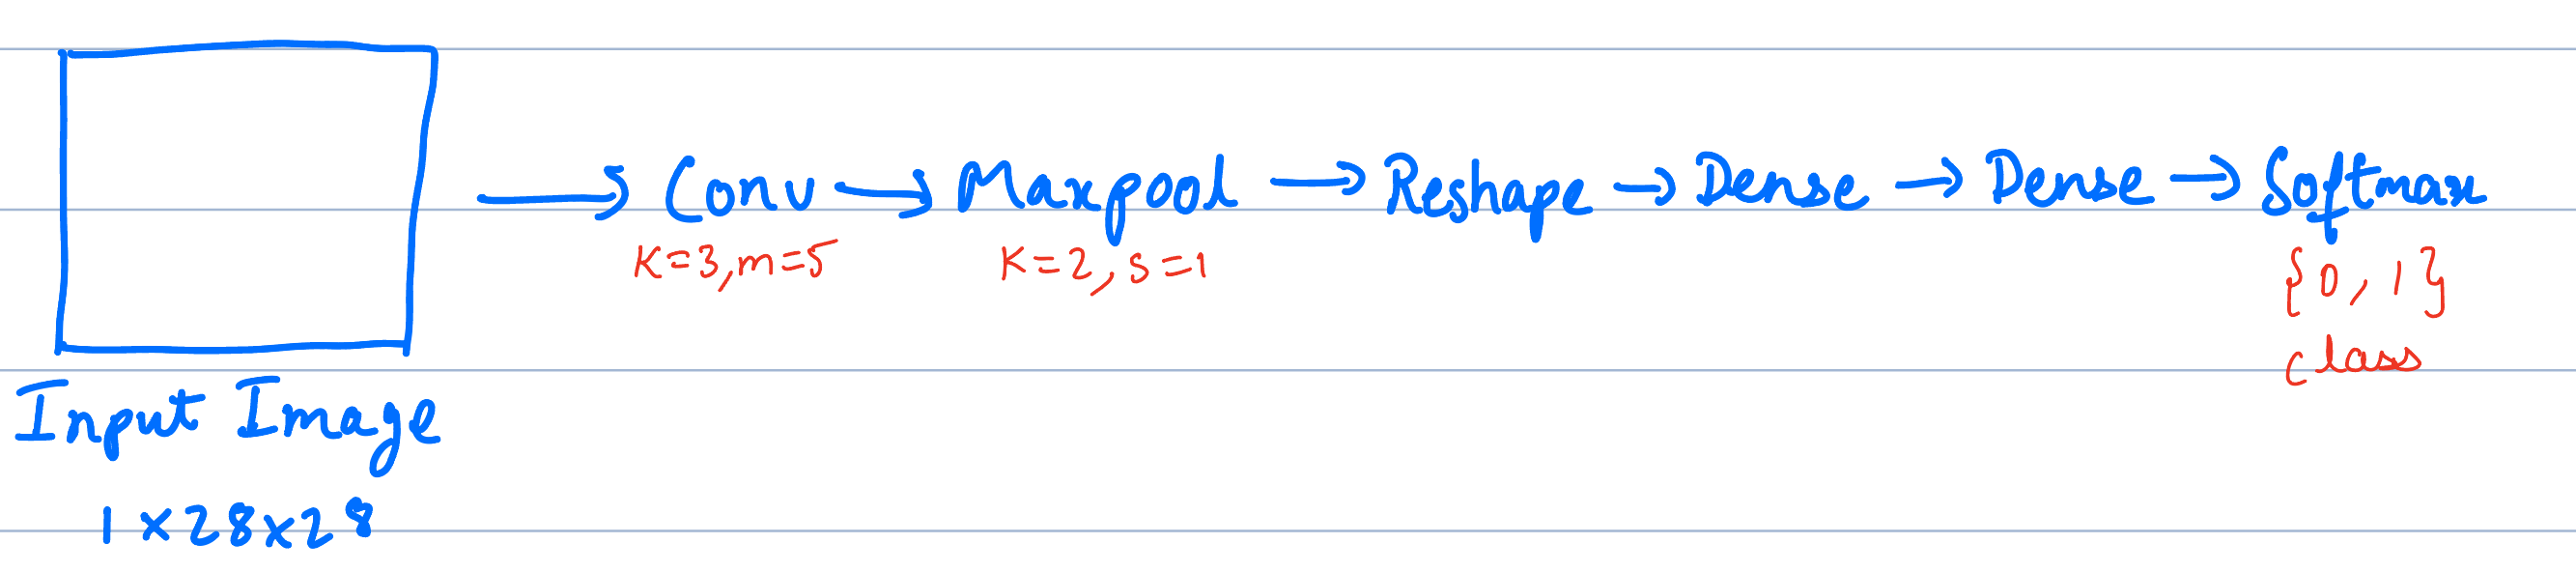

In [103]:
#Define network architecture
network = [
    #input_shape, kernel_size, depth/num_filters
    Convolution((1, 28, 28), 3, 5),
    ReLU(),
    #input_shape, kernel_size, depth
    Maxpool((5,26,26), 2, 5),
    #input_shape, output_shape
    Reshape((5, 25, 25), (5 * 25 * 25, 1)),
    #input_size, output_size
    Dense(5 * 25 * 25, 100),
    TanH(),
    #input_size, output_size
    Dense(100, 2),
    Softmax()
]

In [104]:
def train(network, loss, loss_prime, x_train, y_train, epochs = 10, learning_rate = 0.01):
    for e in range(epochs):
        error = 0
        for x, y in zip(x_train, y_train):

            # Forward pass to predict on the training data, to improve the network
            output = predict(network, x)

            # Summing the losses to optimize the network's weights and biases
            error += loss(y, output)

            # Perform backward pass through every layer by computing the gradients
            # by reversing the network to perform backpropagation
            grad = loss_prime(y, output)
            for layer in reversed(network):
                grad = layer.backward(grad, learning_rate)

        error /= len(x_train)
        print(f"Epoch : {e + 1}/{epochs}, loss = {error}")

#Function to make a prediction using our neural network on a given input
def predict(network, input):
    output = input
    #Performing forward pass to our network through every consecutive layer
    for layer in network:
        output = layer.forward(output)
    return output

In [105]:
train(network, log_loss, log_loss_prime, x_train, y_train, epochs = 10,learning_rate = 0.001)

Epoch : 1/10, loss = 0.18728221275695106
Epoch : 2/10, loss = 0.06138575251334386
Epoch : 3/10, loss = 0.03637072452816225
Epoch : 4/10, loss = 0.02744611497798255
Epoch : 5/10, loss = 0.021283689731817913
Epoch : 6/10, loss = 0.020149208413016834
Epoch : 7/10, loss = 0.014945393652440908
Epoch : 8/10, loss = 0.014656664990990791
Epoch : 9/10, loss = 0.011352792082183382
Epoch : 10/10, loss = 0.012067920564135828


In [106]:
correct = 0
for x, y in zip(x_test, y_test):
    output = predict(network, x)
    if np.equal(np.argmax(output), np.argmax(y)):
       correct += 1

print(f"Accuracy of the Network on Test data is {(correct/len(x_test)) * 100} %")

Accuracy of the Network on Test data is 99.62174940898345 %


In [107]:
def test_random_sample():
    sample_index = random.randint(0, 100)
    x_sample, y_sample = x_test[sample_index], y_test[sample_index]
    output = predict(network, x_sample)
    x_sample = np.squeeze(x_sample, axis = 0)
    plt.rcParams["figure.figsize"] = [2, 2]
    plt.imshow(x_sample)
    plt.axis('off')
    print(f"Predicting on image sample {sample_index} from test data")
    print(f"Prediction : {np.argmax(output)}")
    print(f"Actual : {np.argmax(y_sample)}")

Predicting on image sample 37 from test data
Prediction : 0
Actual : 0


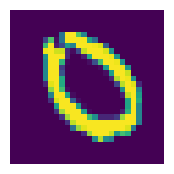

In [110]:
test_random_sample()

In [115]:
def layer_outputs(network, input):
    #Initialize the output
    output = input
    #Intitialize the layer number
    layer_n = 0
    #Iterate through layers in our network
    for layer in network:
        #Since we need only the Convolution, ReLU and Max pool layers, we specify layer_number<=3
        if layer_n <= 3:
            #Plot the image using plt.imshow(), drop the first dimension of our image
            #since we do not need for plotting the image
            if layer_n==0:
                print("Convolution Layer")
            if layer_n==1:
                print("ReLU Layer")
            if layer_n==2:
                print("MaxPool Layer")
            plt.imshow(output[0,:,:])
            #Turning off the axis (not necessary)
            plt.axis('off')

        #Compute the output of the current layer
        output = layer.forward(output)
        #Incremenet the layer number on every iteration
        layer_n = layer_n + 1
        plt.show()

Convolution Layer


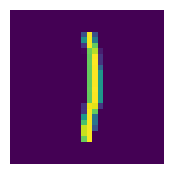

ReLU Layer


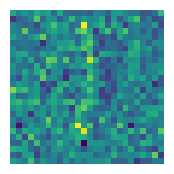

MaxPool Layer


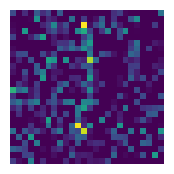

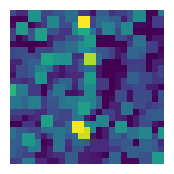

In [116]:
sample_index = random.randint(0, 2115)
x_sample, y_sample = x_test[sample_index], y_test[sample_index]
layer_outputs(network, x_sample)

In [120]:
output = x_sample
print(output.shape)
for layer in network:
        #Pass the image to every layer's forward method
        output = layer.forward(output)
        #Print layer name
        print(layer)
        #Print layer shape
        print(output.shape)

(1, 28, 28)
(5, 26, 26)
(5, 26, 26)
(5, 25, 25)
(3125, 1)
(100, 1)
(100, 1)
(2, 1)
(2, 1)
